In [10]:
!pip install uproot

In [11]:
!pip install uproot awkward vector numpy scipy

In [14]:
import uproot
import awkward as ak
import vector
import numpy as np
from tqdm import tqdm

vector.register_awkward()

# ===============================
# CONFIG
# ===============================
INPUT_ROOT  = "/kaggle/input/cms2011b-requiredbranches/merged.root"
OUTPUT_ROOT = "stage2_jet_substructure.root"

R0   = 0.5
BETA = 1.0
MIN_TRK_PT = 1.0  # GeV

# ===============================
# OPEN FILE
# ===============================
file = uproot.open(INPUT_ROOT)
tree = file["Events"]
branches = tree.keys()

# ===============================
# AUTO BRANCH FINDER
# ===============================
def find_branch(prefix, suffix):
    for b in branches:
        if b.startswith(prefix) and b.endswith(suffix):
            return b
    raise RuntimeError(f"Missing branch: {prefix}*{suffix}")

# ===============================
# JET BRANCHES (AK5 PF)
# ===============================
b_jpt   = find_branch("recoPFJets_ak5PFJets__RECO", "pt_")
b_jeta  = find_branch("recoPFJets_ak5PFJets__RECO", "eta_")
b_jphi  = find_branch("recoPFJets_ak5PFJets__RECO", "phi_")
b_jmass = find_branch("recoPFJets_ak5PFJets__RECO", "mass_")

# ===============================
# JetExtender TRACKS (TracksAtCalo)
# ===============================
JETEXT = "recoJetedmRefToBaseProdTorecoJetExtendedAssociationJetExtendedDatasAssociationVector_ak5JetExtender__RECO"

b_tpt  = find_branch(JETEXT, "mTracksAtCaloP4.fCoordinates.fPt")
b_teta = find_branch(JETEXT, "mTracksAtCaloP4.fCoordinates.fEta")
b_tphi = find_branch(JETEXT, "mTracksAtCaloP4.fCoordinates.fPhi")
b_te   = find_branch(JETEXT, "mTracksAtCaloP4.fCoordinates.fE")

print("✔ Branches resolved")

# ===============================
# LOAD ARRAYS
# ===============================
arrays = tree.arrays(
    [b_jpt, b_jeta, b_jphi, b_jmass,
     b_tpt, b_teta, b_tphi, b_te],
    library="ak"
)

# ===============================
# BUILD JETS (leading jet only)
# ===============================
jets = ak.zip(
    {
        "pt":   arrays[b_jpt],
        "eta":  arrays[b_jeta],
        "phi":  arrays[b_jphi],
        "mass": arrays[b_jmass],
    },
    with_name="Momentum4D"
)

jets = jets[ak.argsort(jets.pt, axis=-1, ascending=False)]
jets = ak.pad_none(jets, 1)
j1 = jets[:, 0]

# ===============================
# BUILD TRACKS
# ===============================
tracks = ak.zip(
    {
        "pt":  arrays[b_tpt],
        "eta": arrays[b_teta],
        "phi": arrays[b_tphi],
        "E":   arrays[b_te],
    },
    with_name="Momentum4D"
)

# ===============================
# JET–TRACK MATCHING
# ===============================
j1_broadcast = ak.broadcast_arrays(j1, tracks.pt)[0]
dR = tracks.deltaR(j1_broadcast)

trk_mask = (dR < R0) & (tracks.pt > MIN_TRK_PT) & (j1.pt > 0)
tracks = tracks[trk_mask]
dR     = dR[trk_mask]

ntrk = ak.num(tracks.pt, axis=1)
pt_sum = ak.sum(tracks.pt, axis=1)

# ===============================
# GIRTH & WIDTH
# ===============================
j1_girth = ak.where(
    pt_sum > 0,
    ak.sum(tracks.pt * dR, axis=1) / pt_sum,
    0.0
)

j1_width = ak.where(
    ntrk > 0,
    np.sqrt(ak.mean(dR**2, axis=1)),
    0.0
)

# ===============================
# ✅ FIXED MAX FRAGMENTATION
# ===============================
raw_maxfrag = ak.where(
    pt_sum > 0,
    ak.max(tracks.pt, axis=1) / j1.pt,
    0.0
)

# Physics-enforced bounds
j1_maxFrag = ak.where(
    raw_maxfrag < 0, 0.0,
    ak.where(raw_maxfrag > 1.0, 1.0, raw_maxfrag)
)


# ===============================
# N-SUBJETTINESS τₙ
# ===============================
def tau_k(k):
    enough = ntrk >= k

    trk_sorted = tracks[ak.argsort(tracks.pt, axis=1, ascending=False)]
    axes = trk_sorted[:, :k]

    trk_b, ax_b = ak.broadcast_arrays(
        trk_sorted[:, :, None],
        axes[:, None, :]
    )

    dRs = trk_b.deltaR(ax_b)
    min_dR = ak.min(dRs, axis=2)

    tau = ak.sum(
        trk_sorted.pt * min_dR**BETA,
        axis=1
    ) / (j1.pt * R0**BETA)

    return ak.where(enough, tau, 0.0)

j1_tau1 = tau_k(1)
j1_tau2 = tau_k(2)
j1_tau3 = tau_k(3)

j1_tau21 = ak.where(j1_tau1 > 0, j1_tau2 / j1_tau1, 0.0)
j1_tau32 = ak.where(j1_tau2 > 0, j1_tau3 / j1_tau2, 0.0)

# ===============================
# MIN PAIRWISE MASS (FIXED)
# ===============================
has_pairs = ntrk >= 2

pairs = ak.combinations(tracks, 2)

# invariant mass squared
pair_m2 = (pairs["0"] + pairs["1"]).mass**2

# clip unphysical negatives (numerical precision)
pair_m2 = ak.where(pair_m2 > 0.0, pair_m2, 0.0)

pair_mass = np.sqrt(pair_m2)

j1_minPairwiseMass = ak.where(
    has_pairs,
    ak.min(pair_mass, axis=1),
    0.0
)


# ===============================
# ENERGY CORRELATION FUNCTION
# ===============================
ECF2 = ak.where(
    has_pairs,
    ak.sum(
        pairs["0"].pt * pairs["1"].pt *
        pairs["0"].deltaR(pairs["1"]),
        axis=1
    ),
    0.0
)

j1_ECF_ratio = ak.where(pt_sum > 0, ECF2 / (pt_sum**2), 0.0)

# ===============================
# FLATTEN (ROOT-SAFE)
# ===============================
def flat(x):
    return np.asarray(ak.fill_none(x, 0.0))

out = {
    "j1_tau1": flat(j1_tau1),
    "j1_tau2": flat(j1_tau2),
    "j1_tau3": flat(j1_tau3),
    "j1_tau21": flat(j1_tau21),
    "j1_tau32": flat(j1_tau32),
    "j1_girth": flat(j1_girth),
    "j1_width": flat(j1_width),
    "j1_maxFragmentation": flat(j1_maxFrag),
    "j1_minPairwiseMass": flat(j1_minPairwiseMass),
    "j1_ECF_ratio": flat(j1_ECF_ratio),
}

# ===============================
# WRITE ROOT
# ===============================
with uproot.recreate(OUTPUT_ROOT) as fout:
    fout["Events"] = out

print(f"\n✅ Stage-2 Jet Substructure written → {OUTPUT_ROOT}")


✔ Branches resolved

✅ Stage-2 Jet Substructure written → stage2_jet_substructure.root


In [15]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE = "/kaggle/working/stage2_jet_substructure.root"

with uproot.open(FILE) as f:
    tree = f["Events"]
    df = tree.arrays(library="pd")

print(df.shape)
df.head()


(452055, 10)


,j1_tau1,j1_tau2,j1_tau3,j1_tau21,j1_tau32,j1_girth,j1_width,j1_maxFragmentation,j1_minPairwiseMass,j1_ECF_ratio
0,0.000000,0.0,0.0,0.0,0.0,0.127497,0.127497,0.365821,0.000000,0.000000
1,0.092851,0.0,0.0,0.0,0.0,0.154104,0.309895,0.617610,19.062397,0.056966
2,0.000000,0.0,0.0,0.0,0.0,0.011754,0.011754,0.431132,0.000000,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.108522,0.108522,0.280483,0.000000,0.000000
4,0.007344,0.0,0.0,0.0,0.0,0.016416,0.274876,0.855114,12.717482,0.004204



Total events: 452055
Available branches: ['j1_tau1', 'j1_tau2', 'j1_tau3', 'j1_tau21', 'j1_tau32', 'j1_girth', 'j1_width', 'j1_maxFragmentation', 'j1_minPairwiseMass', 'j1_ECF_ratio']

Basic stats:
j1_tau1                min/max: 0.0 1.428048849105835
j1_tau2                min/max: 0.0 0.7326045036315918
j1_tau3                min/max: 0.0 0.29540303349494934
j1_tau21               min/max: 0.0 1.0
j1_tau32               min/max: 0.0 1.0
j1_girth               min/max: 0.0 0.4999386668205261
j1_width               min/max: 0.0 0.4999386630583057
j1_maxFragmentation    min/max: 0.0 1.0
j1_minPairwiseMass     min/max: 0.0 5296.16899277204
j1_ECF_ratio           min/max: 0.0 0.25950040269297636

Event counts:
τ1 > 0: 232793
τ2 > 0: 75288
τ3 > 0: 13362
Physics mask: 232793

Consistency checks:
τ21 > 1 events: 0
τ32 > 1 events: 0


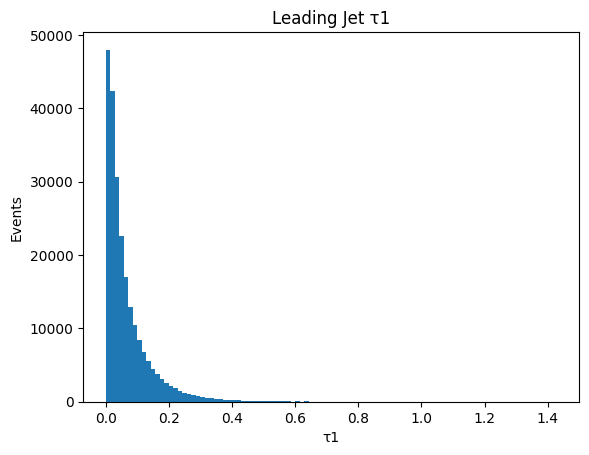

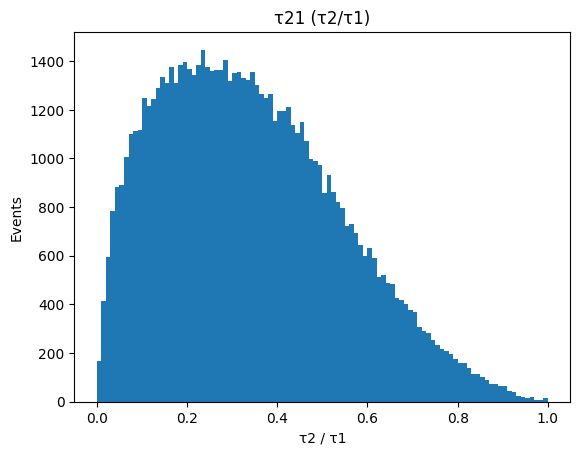

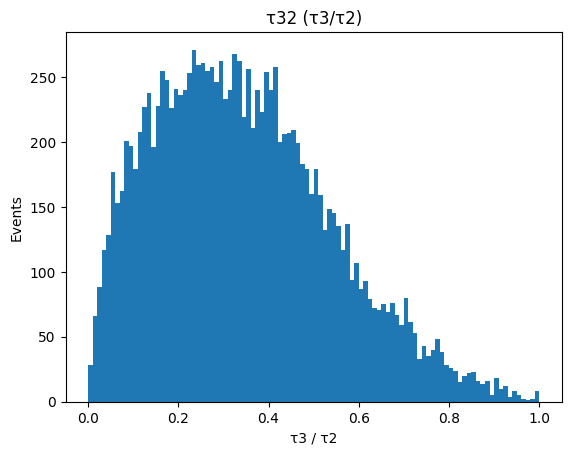

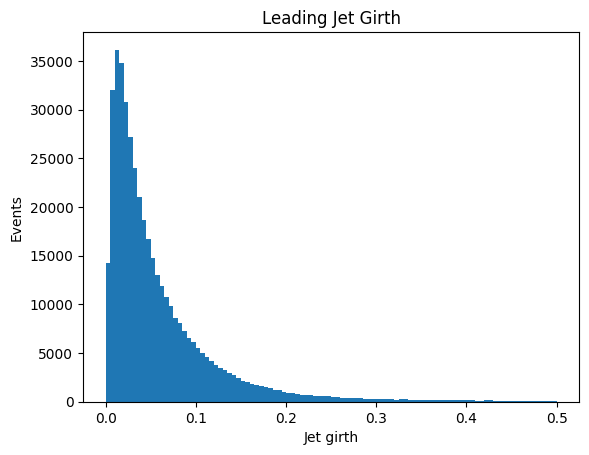

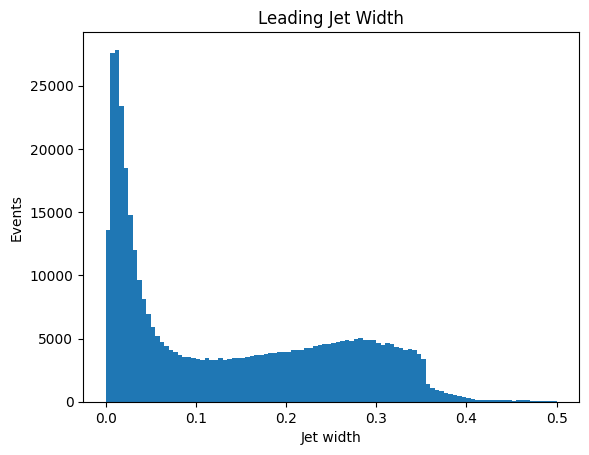

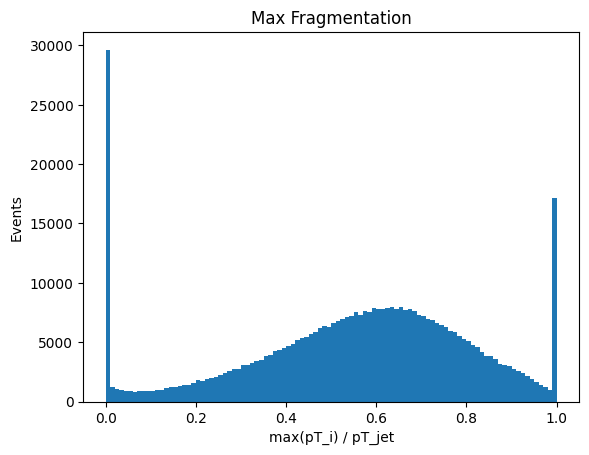

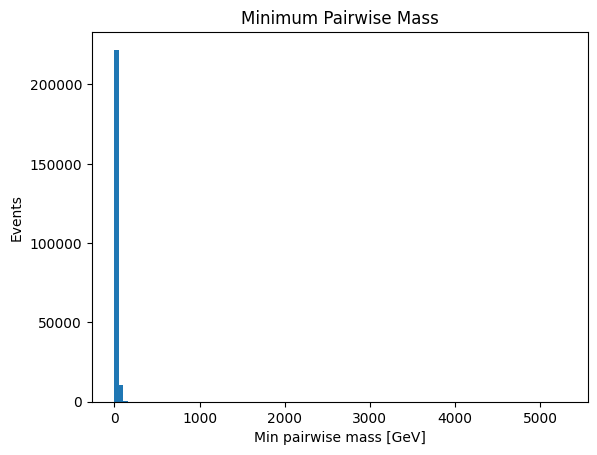

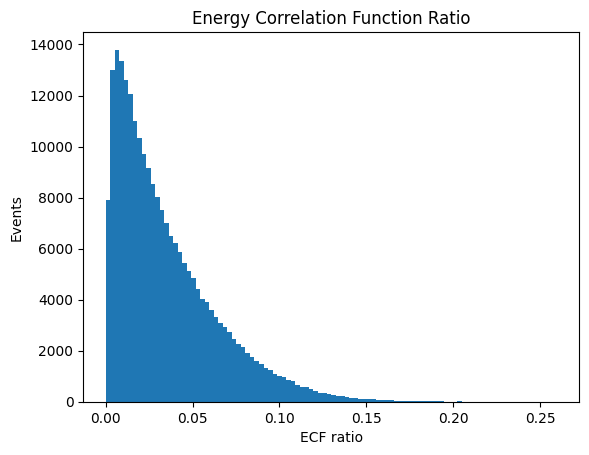

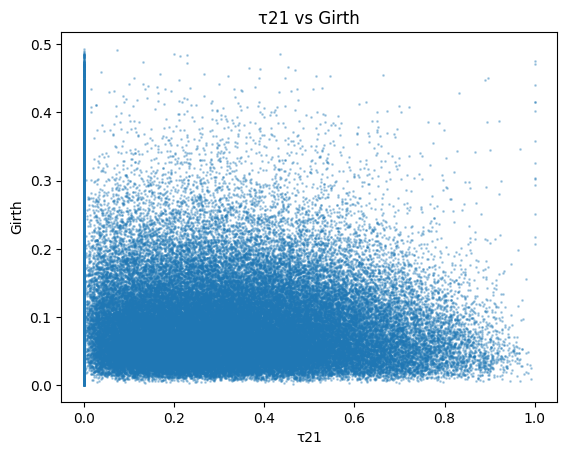

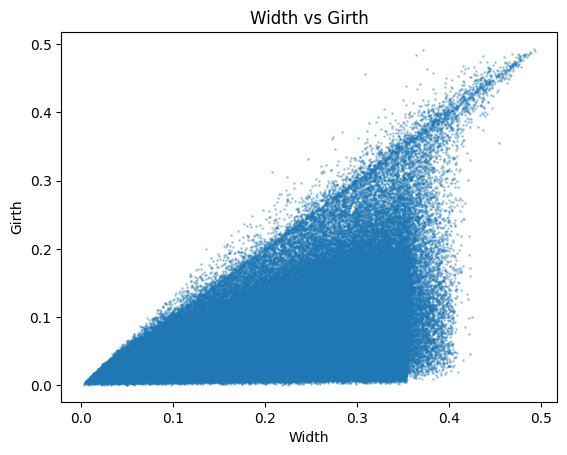


✔ Stage-2 Jet Substructure EDA complete.


In [16]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------
# Load ROOT file
# ---------------------------------
f = uproot.open("/kaggle/working/stage2_jet_substructure.root")
tree = f["Events"]
arr = tree.arrays(library="ak")

print("\nTotal events:", len(arr))
print("Available branches:", arr.fields)

# ---------------------------------
# Basic sanity checks
# ---------------------------------
print("\nBasic stats:")

for k in arr.fields:
    print(
        f"{k:22s} min/max:",
        ak.min(arr[k]),
        ak.max(arr[k])
    )

# ---------------------------------
# Event-level masks (CRITICAL)
# ---------------------------------
mask_tau1 = arr.j1_tau1 > 0
mask_tau2 = arr.j1_tau2 > 0
mask_tau3 = arr.j1_tau3 > 0
mask_phys = (arr.j1_tau1 > 0) & (arr.j1_girth > 0)

print("\nEvent counts:")
print("τ1 > 0:", ak.sum(mask_tau1))
print("τ2 > 0:", ak.sum(mask_tau2))
print("τ3 > 0:", ak.sum(mask_tau3))
print("Physics mask:", ak.sum(mask_phys))

# ---------------------------------
# Consistency checks
# ---------------------------------
bad_tau21 = ak.sum(
    (arr.j1_tau21 > 1) & mask_tau2
)
bad_tau32 = ak.sum(
    (arr.j1_tau32 > 1) & mask_tau3
)

print("\nConsistency checks:")
print("τ21 > 1 events:", bad_tau21)
print("τ32 > 1 events:", bad_tau32)

# ---------------------------------
# 1) τ1 distribution
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_tau1[mask_tau1]),
    bins=100
)
plt.xlabel("τ1")
plt.ylabel("Events")
plt.title("Leading Jet τ1")
plt.show()

# ---------------------------------
# 2) τ21 distribution
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_tau21[mask_tau2]),
    bins=100,
    range=(0, 1)
)
plt.xlabel("τ2 / τ1")
plt.ylabel("Events")
plt.title("τ21 (τ2/τ1)")
plt.show()

# ---------------------------------
# 3) τ32 distribution
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_tau32[mask_tau3]),
    bins=100,
    range=(0, 1)
)
plt.xlabel("τ3 / τ2")
plt.ylabel("Events")
plt.title("τ32 (τ3/τ2)")
plt.show()

# ---------------------------------
# 4) Girth distribution
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_girth[arr.j1_girth > 0]),
    bins=100
)
plt.xlabel("Jet girth")
plt.ylabel("Events")
plt.title("Leading Jet Girth")
plt.show()

# ---------------------------------
# 5) Width distribution
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_width[arr.j1_width > 0]),
    bins=100
)
plt.xlabel("Jet width")
plt.ylabel("Events")
plt.title("Leading Jet Width")
plt.show()

# ---------------------------------
# 6) Max fragmentation
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_maxFragmentation),
    bins=100,
    range=(0, 1)
)
plt.xlabel("max(pT_i) / pT_jet")
plt.ylabel("Events")
plt.title("Max Fragmentation")
plt.show()

# ---------------------------------
# 7) Min pairwise mass
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_minPairwiseMass[arr.j1_minPairwiseMass > 0]),
    bins=100
)
plt.xlabel("Min pairwise mass [GeV]")
plt.ylabel("Events")
plt.title("Minimum Pairwise Mass")
plt.show()

# ---------------------------------
# 8) Energy correlation ratio
# ---------------------------------
plt.figure()
plt.hist(
    ak.to_numpy(arr.j1_ECF_ratio[arr.j1_ECF_ratio > 0]),
    bins=100
)
plt.xlabel("ECF ratio")
plt.ylabel("Events")
plt.title("Energy Correlation Function Ratio")
plt.show()

# ---------------------------------
# 9) Correlation: τ21 vs girth
# ---------------------------------
plt.figure()
plt.scatter(
    ak.to_numpy(arr.j1_tau21[mask_phys]),
    ak.to_numpy(arr.j1_girth[mask_phys]),
    s=1,
    alpha=0.3
)
plt.xlabel("τ21")
plt.ylabel("Girth")
plt.title("τ21 vs Girth")
plt.show()

# ---------------------------------
# 10) Correlation: width vs girth
# ---------------------------------
plt.figure()
plt.scatter(
    ak.to_numpy(arr.j1_width[mask_phys]),
    ak.to_numpy(arr.j1_girth[mask_phys]),
    s=1,
    alpha=0.3
)
plt.xlabel("Width")
plt.ylabel("Girth")
plt.title("Width vs Girth")
plt.show()

print("\n✔ Stage-3 Jet Substructure EDA complete.")
